<h2> Case Study: Association Rule Mining and Time Series Analysis on Retail Store Data </h2>

In this case study, you will perform Association Rule Mining on data to discover the rules that govern purchases in the store.
Moreover, you will be performing Time Series Analysis to understand how the store's revenue is changing with time.

## Discovering purchasing patterns using Market Basket Analysis

In [1]:
#Import the required libraries
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
import matplotlib

In [2]:
#Read the uploaded csv file
data = pd.read_csv("data.csv",encoding = "ISO-8859-1")
print (data.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


In [3]:
data.shape

(541909, 8)

## Exploratory Data Analysis

Since this is a huge dataset, let us understand the number of <b>unique transactions</b> in the dataset.

In [4]:
len(data.groupby(['InvoiceNo'])['Quantity'].count())

25900

Who is the <b>highest billed</b> customer?

In [5]:
max_buy = pd.DataFrame(data.groupby(['CustomerID'])['UnitPrice'].sum().reset_index())
max_buy = max_buy.sort_values(by='UnitPrice', ascending=False)
max_buy.head()

,CustomerID,UnitPrice
1300,14096.0,41376.33
2027,15098.0,40278.90
1895,14911.0,31060.66
328,12744.0,25108.89
2722,16029.0,24111.14


In [6]:
#Let us take a look at the purchases made by the highest billed customer
highest_cust = data[data['CustomerID']==14096]
highest_cust = highest_cust.sort_values(by='UnitPrice', ascending=False)
highest_cust.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
528082,580727,DOT,DOTCOM POSTAGE,1,12/5/2011 17:17,1599.26,14096.0,United Kingdom
508459,579196,DOT,DOTCOM POSTAGE,1,11/28/2011 15:54,1526.76,14096.0,United Kingdom
467436,576339,DOT,DOTCOM POSTAGE,1,11/14/2011 15:27,1500.36,14096.0,United Kingdom
494728,578270,DOT,DOTCOM POSTAGE,1,11/23/2011 13:39,1270.06,14096.0,United Kingdom
528087,C580726,CRUK,CRUK Commission,-1,12/5/2011 17:17,1100.44,14096.0,United Kingdom


You can observe that products whose description is `DOTCOM POSTAGE`are priced really high.

## Feature Engineering

In order to perform <b>Association Rule Mining</b>, we need the data to be in a <b>user*product matrix</b> format.

In [7]:
basket = pd.pivot_table(data,index='InvoiceNo', columns='Description',values='Quantity', fill_value=0)
basket.shape

(24446, 4223)

For us, whether an item is present in a transaction is the only thing that matters. We do not care about the <b>no.of units sold</b> in a transaction for performing Association Rule Mining.

In [8]:
#This is a function to replace natural number with 1
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)
basket_sets.drop('POSTAGE', inplace=True, axis=1) #dropping off the records which have been posted


Let us generate <b>'Frequent Item Sets'</b> by applying the <b>Apriori algorithm</b>. We will consider only those frequent item sets that have a support value greater than 0.03.

In [9]:
frequent_itemsets = apriori(basket_sets, min_support=0.03, use_colnames=True)
frequent_itemsets.head()

,support,itemsets
0,0.039066,(6 RIBBONS RUSTIC CHARM)
1,0.033871,(60 TEATIME FAIRY CAKE CASES)
2,0.040088,(ALARM CLOCK BAKELIKE GREEN)
3,0.032030,(ALARM CLOCK BAKELIKE PINK)
4,0.042993,(ALARM CLOCK BAKELIKE RED )


Let us now generate the association rules from the dataset along with the <b>lift</b> and <b>confidence</b> values

In [10]:
rules = association_rules(frequent_itemsets, metric="lift")
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.041520,0.043606,0.031416,0.756650,17.351850,0.029606,3.930120
1,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.043606,0.041520,0.031416,0.720450,17.351850,0.029606,3.428656
2,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.049824,0.085576,0.033748,0.677340,7.915034,0.029484,2.834015
3,(JUMBO BAG RED RETROSPOT),(JUMBO BAG PINK POLKADOT),0.085576,0.049824,0.033748,0.394359,7.915034,0.029484,1.568878


We will only consider the most important rules - the ones which have <b>lift > 6</b> and <b>confidence > 0.8</b>

In [11]:
rules[ (rules['lift'] >= 6) &
       (rules['confidence'] >= 0.6) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.041520,0.043606,0.031416,0.75665,17.351850,0.029606,3.930120
1,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.043606,0.041520,0.031416,0.72045,17.351850,0.029606,3.428656
2,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.049824,0.085576,0.033748,0.67734,7.915034,0.029484,2.834015


From the above analysis, you can conclude that <b>Green Regency Teacup and Saucer</b> and <b>Roses Regency Teacup and Saucer</b> have been mostly bought together by customers. Also, you can show <b>Jumbo Bag red retrospot</b> as a possible product recommendation for customers who buy <b>Jumbo Bag Pink Polkadot.</b> 

This is the power of <b>Apriori Algorithm </b>- it helps you in discovering purchasing relationships by analysing your market basket data.

# Time Series Analysis

Retailer was fascinated by the Market Basket Analysis and decided to further analyze the transaction data by performing <b>Time Series Analysis</b>. The goal is to understand how the store's <b>revenue</b> is changing with time.

## Data Preparation

We need to convert the `InvoiceDate` column to a <b>datetime</b> column.

In [12]:
data.InvoiceDate.head()

0    12/1/2010 8:26
1    12/1/2010 8:26
2    12/1/2010 8:26
3    12/1/2010 8:26
4    12/1/2010 8:26
Name: InvoiceDate, dtype: object

In [13]:
#Convert to datetime format
data['Invoice_Date']=pd.to_datetime(data['InvoiceDate'])

In [14]:
data['Invoice_Date'].head()

0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: Invoice_Date, dtype: datetime64[ns]

We will also extract the <b>week</b> and <b>year</b> details from the `Invoice_Date` column.

In [15]:
data['week_year']=data['Invoice_Date'].dt.week

In [16]:
data['Year'] = data['Invoice_Date'].dt.year

In [17]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Invoice_Date,week_year,Year
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,2010-12-01 08:26:00,48,2010
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,48,2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,2010-12-01 08:26:00,48,2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,48,2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,48,2010


In [18]:
data.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Invoice_Date,week_year,Year
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,2011-12-09 12:50:00,49,2011
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,2011-12-09 12:50:00,49,2011
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,2011-12-09 12:50:00,49,2011
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France,2011-12-09 12:50:00,49,2011
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France,2011-12-09 12:50:00,49,2011


In [19]:
np.sort(data['week_year'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51],
      dtype=int64)

If you notice, as the data is spread across two separate years, we need to maintain the <b>sequence</b> of week numbers.

In [20]:
data = data[((data.Year == 2011) & (data.week_year <= 26)) | ((data.Year ==2010) & (data.week_year >= 28))]

In [21]:
import operator
#Keeping the trend of the weeks in the data and hence adding 53 to the weeks of 2016. week_year is just an index
data['week_year']=np.where((operator.and_(data['week_year']<=26, data['Year']==2011)),data['week_year']+53,data['week_year'])

In [22]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Invoice_Date,week_year,Year
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,2010-12-01 08:26:00,48,2010
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,48,2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,2010-12-01 08:26:00,48,2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,48,2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,48,2010
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom,2010-12-01 08:26:00,48,2010
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom,2010-12-01 08:26:00,48,2010
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom,2010-12-01 08:28:00,48,2010
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom,2010-12-01 08:28:00,48,2010
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom,2010-12-01 08:34:00,48,2010


Let us create the `Revenue` column.

In [23]:
data['Revenue']=data.Quantity * data.UnitPrice

## Data Exploration

Create a `category` column that extracts the category of the item from description.

In [24]:
data['category'] = data.Description.str.split().str[-1]

print  (data.category.value_counts().head(10))


DESIGN       12103
HOLDER        7094
SIGN          6709
RETROSPOT     6620
BOX           6187
BAG           5035
CASES         4268
SET           4169
MUG           3454
BUNTING       3309
Name: category, dtype: int64


Extract the <b>month</b> details from the `InvoiceDate` column.

In [25]:
data.month = data.InvoiceDate.str.split('/').str[0]

print ("Sales by Month : \n", data.month.value_counts())

Sales by Month : 
 12    42481
5     37030
6     36874
3     36748
1     35147
4     29916
2     27707
7      1629
Name: InvoiceDate, dtype: int64


C:\Users\Prerna\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


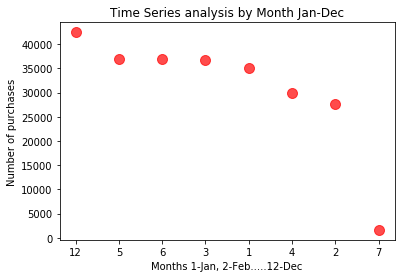

In [26]:
plt.scatter(data.month.value_counts().keys(),data.month.value_counts(), c='r', s=100, alpha=0.7)
plt.xlabel('Months 1-Jan, 2-Feb.....12-Dec')
plt.ylabel('Number of purchases')
plt.title('Time Series analysis by Month Jan-Dec')
plt.show()

Many purchases seem to happen during <b>Christmas</b> time. 

Let us group all the transactions by `week_year`. 

In [27]:
time_df = data.groupby('week_year').sum()

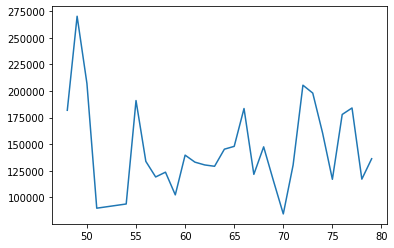

In [29]:
#Let us see the original data spread
plt.plot(time_df.Revenue)

Since there is a lot of <b>variance</b> across different weeks, this is a difficult <b>timeseries</b> to model. Let us smoothen it by using <b>log transformation</b>.

In [30]:
time_df.head()

,Quantity,UnitPrice,CustomerID,Year,Revenue
week_year,,,,,
48,79062,38727.19,122249393.0,20389440,181847.25
49,118448,144262.85,153871225.0,33341880,270287.03
50,105446,51191.06,111863691.0,22403460,207052.17
51,39272,26339.75,28713439.0,9252030,89770.57
54,73491,60913.67,81041033.0,15424370,93720.93


In [31]:
log_revenue = np.log(time_df.Revenue)
log_revenue[0:10]

week_year
48    12.110922
49    12.507240
50    12.240726
51    11.405012
54    11.448077
55    12.160002
56    11.803974
57    11.688028
58    11.725147
59    11.535635
Name: Revenue, dtype: float64

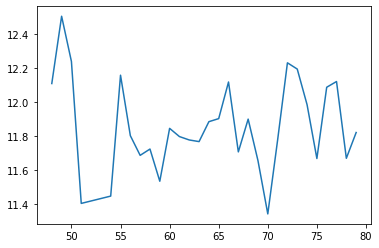

In [32]:
#Let us see the original data spread
plt.plot(log_revenue)

Still, we do not see a major difference in the variance. Let us do a <b>first-order differencing</b> on the time series and see if it helps.

In [33]:
log_revenue_diff = log_revenue - log_revenue.shift()

In [34]:
log_revenue_diff.dropna(inplace=True)
log_revenue_diff[1:10]

week_year
50   -0.266514
51   -0.835714
54    0.043064
55    0.711926
56   -0.356029
57   -0.115946
58    0.037119
59   -0.189512
60    0.311364
Name: Revenue, dtype: float64

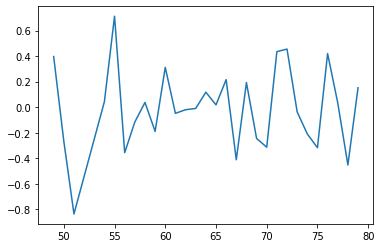

In [35]:
#Data after log normalizing & 1st order differencing
plt.plot(log_revenue_diff)

First-order differencing slightly normalized the variance. You can try second-order and third-order differencing to further normalize the variance.

## Stationarity Test

Visualizations can only provide so much information about a Time Series. Let us apply <b>Dickey Fuller test</b> to verify if the timeseries is stationary or not.

In [36]:
from statsmodels.tsa.stattools import adfuller

In [37]:
#ceating a function to test wheather the time series is stationary or not
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean() 
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

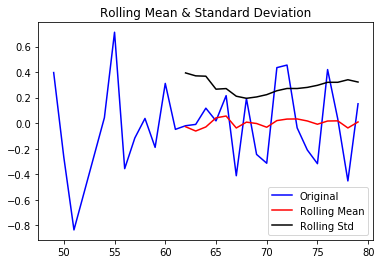

Results of Dickey-Fuller Test:
Test Statistic                 -3.036167
p-value                         0.031652
#Lags Used                      6.000000
Number of Observations Used    22.000000
Critical Value (1%)            -3.769733
Critical Value (5%)            -3.005426
Critical Value (10%)           -2.642501
dtype: float64


In [38]:
test_stationarity(log_revenue_diff)

Since the p-value is less than 0.05, we reject the null hypothesis that the Time Series is not stationary. We are dealing with a stationary time series and the differenced value(d) is 1. 

## Forecast Revenue using ARIMA model

In order to forecast revenue using ARIMA, we need to find the <b>(p,d,q)</b> values. From the above analysis, we already know the 'd' value to be 2.

In [39]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
lag_acf = acf(log_revenue_diff.values, nlags = 20)
lag_pacf = pacf(log_revenue_diff.values, nlags = 20)

C:\Users\Prerna\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
C:\Users\Prerna\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


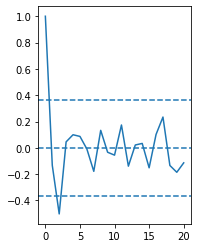

In [40]:
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(log_revenue_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_revenue_diff)),linestyle='--')

From the above <b>'ACF'</b> plot, we can conclude that the <b>'q'</b> value is 2.

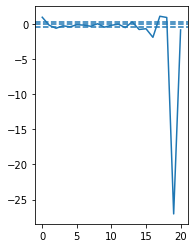

In [41]:
plt.subplot(121) 
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(log_revenue_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_revenue_diff)),linestyle='--')

From the above <b>'PACF'</b> plot, we can conclude that the <b>'p'</b> value is 0.

Let us now build the ARIMA model with the (p,d,q) values as (0,1,2)

In [42]:
from statsmodels.tsa.arima_model import ARIMA

C:\Users\Prerna\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Prerna\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 1.9771')

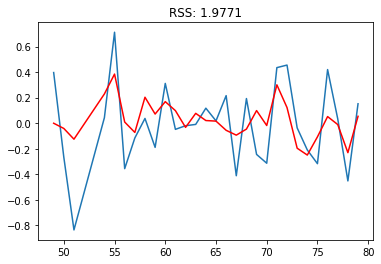

In [43]:
# ARIMA model
model = ARIMA(log_revenue, order=(0, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(log_revenue_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-log_revenue_diff)**2))

Let us store the ARIMA model predictions in a Series object.

In [44]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

week_year
49   -0.000488
50   -0.041364
51   -0.125267
54    0.228880
55    0.384337
dtype: float64


As we need to forecast the <b>actual revenue numbers</b>, we need to renormalize the obtained values. Let us first calculate the <b>cumulative sum of the log differences.</b>

In [45]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

week_year
49   -0.000488
50   -0.041853
51   -0.167120
54    0.061760
55    0.446097
dtype: float64


Get the base revenue value from the <b>first week</b> in the dataset.

In [46]:
log_revenue.iloc[0]

12.110922327947232

Now add the cumulative sum values to the base value. We will obtain the log value for predicted revenues for all the weeks.

In [47]:
predictions_ARIMA_log = pd.Series(log_revenue.iloc[0], index=log_revenue.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

week_year
48    12.110922
49    12.110434
50    12.069070
51    11.943802
54    12.172683
dtype: float64

Now convert the log values obtained above to <b>actual revenue numbers</b> and plot the forecasted revenue alongside actual revenue.

In [48]:
#Actual Revenue
print (time_df.Revenue)

week_year
48    181847.250
49    270287.030
50    207052.170
51     89770.570
54     93720.930
55    190994.960
56    133782.910
57    119136.810
58    123642.180
59    102296.930
60    139664.580
61    133069.930
62    130435.560
63    129180.960
64    145262.610
65    147909.800
66    183501.710
67    121598.220
68    147459.771
69    115461.250
70     84382.660
71    130354.310
72    205445.230
73    198031.530
74    160569.820
75    116932.520
76    177916.870
77    184016.500
78    117086.710
79    136287.440
Name: Revenue, dtype: float64


week_year
48    181847.250000
49    181758.459908
50    174393.507293
51    153860.619000
54    193432.233124
55    284082.269559
56    286620.036209
57    266577.943153
58    326589.392607
59    350782.010699
60    415140.333353
61    457953.984148
62    443120.973688
63    478548.777707
64    488548.199561
65    496497.907005
66    469547.566621
67    427526.719972
68    408159.447020
69    450469.474593
70    442298.822429
71    597161.518552
72    674828.510267
73    554730.562093
74    432204.121520
75    388334.999576
76    408932.583649
77    404554.102284
78    321154.309375
79    338885.167184
dtype: float64


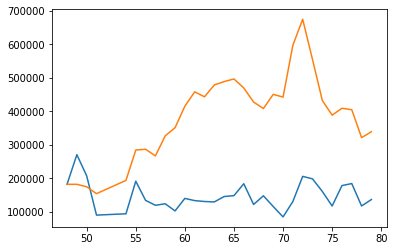

In [49]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
print (predictions_ARIMA)
plt.plot(time_df.Revenue)
plt.plot(predictions_ARIMA)

Above plot showcases the <b>forecasted revenue</b> from the ARIMA model in 'Yellow'. As you can see, our forecast was able to capture the trend but did not capture the level. This is due to the dataset being small and also the fact that between weeks <b>51-55</b>, a lot of volatility seems to be present in the sales. This might be due to sales waning after the festive period. We need more data to model this volatility and make our forecast more accurate. 